# import 

In [982]:

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from ast import literal_eval
from tqdm import tqdm
import math
from scipy.spatial import distance


# loop over and load in behavioural data from useable mirs
def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path

def load_behav_sync(full_org_dat_path):
    # List all items in the directory
    items = os.listdir(os.path.join(full_org_dat_path, 'behav_sync/'))
    # Find the string that contains 'task'
    task_item = next((item for item in items if 'task' in item), None)
    # Add it to the path
    if task_item:
        task_path = os.path.join(full_org_dat_path, 'behav_sync/', task_item)
        print(task_path)
    else:
        print("No task dir found in behav_sync")
        
    behav_sync_csv = next((item for item in os.listdir(task_path) if 'Behav' in item), None)
    behav_sync_csv_path = os.path.join(task_path,behav_sync_csv)
    
    transition_sync_csv = next((item for item in os.listdir(task_path) if 'Transition' in item), None)
    transition_sync_csv_path = os.path.join(task_path,transition_sync_csv)

    return pd.read_csv(behav_sync_csv_path), pd.read_csv(transition_sync_csv_path)

def find_awake_ppseq_base_path(mir,awake_ppseq_path):
    awake_ppseq_mirs = np.array(['_'.join(item.split('_')[0:3]) for item in os.listdir(awake_ppseq_path)])
    awake_file_mir = None
    for ind,item in enumerate(awake_ppseq_mirs):
        if item in mir:
            awake_file_mir = os.listdir(awake_ppseq_path)[ind]
    if awake_file_mir == None:
        raise Exception("No awake file found for mir")
    else:
        return(os.path.join(awake_ppseq_path,awake_file_mir))
    
def get_sequence_regions(mir,awake_ppseq_base_path,sequence_order):
    standard_space_path = awake_ppseq_base_path + r'//analysis_output/reordered_recolored/fixed_standard_space//'
    overlap_positions_standard_space = np.load(standard_space_path + 'overlap_positions_standard_space.npy',allow_pickle=True)

    mir_row = None
    for ind, row in sequence_order.iterrows():
        if row.mir in mir:
            mir_row = row
    seq_order = literal_eval(mir_row.seq_order)
    continuous_regions = []
    fig, ax = plt.subplots(1,1,figsize=(8, 2))
    for i,seq in enumerate(seq_order):
        ax.plot(overlap_positions_standard_space[seq],np.ones(len(overlap_positions_standard_space[seq]))*i,'o')
        continuous_regions += [find_largest_continuous_region(overlap_positions_standard_space[seq])]

    # create new df 
    continuous_regions_df = pd.DataFrame(continuous_regions,columns=['start','end'])
    continuous_regions_df['sequence'] = seq_order
    return continuous_regions_df


def find_largest_continuous_region(positions, max_gap=5, circular_max=100):
    # Sort positions for easier processing
    positions = sorted(positions)
    
    # Identify continuous regions
    regions = []
    current_region = [positions[0]]
    
    for i in range(1, len(positions)):
        if positions[i] - positions[i - 1] < max_gap:
            current_region.append(positions[i])
        else:
            regions.append(current_region)
            current_region = [positions[i]]
    
    regions.append(current_region)  # Append the last region
    
    # Handle circular case (if the first and last regions can be merged)
    if regions and len(regions) > 1:
        first_region = regions[0]
        last_region = regions[-1]
        
        if (circular_max - last_region[-1] + first_region[0]) < max_gap:
            merged_region = last_region + first_region
            regions = regions[1:-1]  # Remove first and last
            regions.append(merged_region)
    
    # Find the largest region
    largest_region = max(regions, key=lambda r: r[-1] - r[0] if r[-1] >= r[0] else (r[-1] + circular_max - r[0]))
    
    # Determine start and end points
    start = largest_region[0]
    end = largest_region[-1]
    
    return start, end

def get_dlc_data(Tracking_data_path,interp,val):
    # Load in '.h5' file:
    h5_read=pd.read_hdf(Tracking_data_path)
    # Access the head center      
    scorer =  h5_read.columns.tolist()[0][0]

    colum_headings = h5_read[scorer].columns
    bodyparts = np.unique([item[0] for item in colum_headings])

    output = {}
    for name in bodyparts:
        print(name)
        dat_ =  h5_read[scorer][name]
        if interp:
            dat_interped=clean_and_interpolate(dat_,val)
        output[name] =[dat_interped]
    return output


def clean_and_interpolate(data,threshold):

    bad_confidence_inds = np.where(data.likelihood.values<threshold)[0]
    newx = data.x.values
    newx[bad_confidence_inds] = 0
    newy = data.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    data['interped_x'] = interped_x
    data['interped_y'] = interped_y
    
    return data

def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                   

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                 

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
    print('function exiting')
    return(coords_list)

def get_tracking_data_EJT_data(full_org_dat_path):
    track_path = os.path.join(full_org_dat_path,'video/tracking/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and 'task' in tracking_file and '.h5' in tracking_file:
            task_tracking_csv = os.path.join(full_track_path,tracking_file)
            break
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and 'port' in tracking_file and '.h5' in tracking_file:
            port_tracking_csv = os.path.join(full_track_path,tracking_file)
            break
        
    # load in tracking data:        
    back_head_centre = get_dlc_data(task_tracking_csv,interp = True,val = 0.9995)
    back_ports = get_dlc_data(port_tracking_csv,interp = True,val = 0.9995)

    if 'head_centre' in list(back_head_centre):
        back_head_centre_df = back_head_centre['head_centre'][0] 
        
    p1,p2,p3,p4,p5 = back_ports['port2'][0],back_ports['port1'][0],back_ports['port6'][0],back_ports['port3'][0],back_ports['port7'][0]
        
    return back_head_centre_df,p1,p2,p3,p4,p5

def find_error_rates(transition_sync_df): 

    Correct = [21,16,63,37,72]
    Error = [23,24,25,26,27,28,12,13,14,15,17,18,61,62,64,65,67,68,31,32,34,35,36,38]
    Neutral = [11,22,33,66,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,71,73,74,75,76,77,78,81,82,83,84,85,86,87,88]

    filt_df = transition_sync_df[transition_sync_df.in_in_Latency < 2]

    corrects = 0
    errors = 0
    neutral = 0
    for transit in filt_df.Transition_type.values:
        if transit in Correct:
            corrects += 1
        elif transit in Error:
            errors += 1
        elif transit in Neutral:
            neutral += 1
        else:
            raise Exception("Transition type not found!")
    total = corrects + errors + neutral
    return corrects/total,errors/total,neutral/total

def sequence_contains_sequence(haystack_seq, needle_seq):
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            return True
    return False
            
def parts(list_, indices):
    indices = [0]+indices+[len(list_)]
    return [list_[v:indices[k+1]] for k, v in enumerate(indices[:-1])]

def RemoveSlowSequences(split,split2):
    timefiltered_split = []
    for i,item in enumerate(split2):
        if item[0] == 1:
            timefiltered_split = timefiltered_split + [split[i]]
    return timefiltered_split
            
#### align to first port pokes and remove single transitions (these dont count as sequences)

def aligntofirstpokeandremovesingletransits(timesplitseqs,timesplitlatencies):
    
    newseqs = []
    newlatencies = []
    # align to first poke:
    for index_1,fragments in enumerate(timesplitseqs):
        current_newseqs = []
        current_newlatencies = []
        count = -1
        seqs = False
        for index_2,sequence in enumerate(fragments):
            for index_3,transit in enumerate(sequence):
                if not str(transit)[0] == str(transit)[1]: # remove repeat pokes
                    if str(transit)[0] == '2':
                        seqs = True
                        current_newseqs = current_newseqs + [[]]
                        current_newlatencies = current_newlatencies + [[]]
                        count = count + 1
                        current_newseqs[count] = current_newseqs[count] + [transit]
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
                    elif seqs == True:
                        current_newseqs[count] = current_newseqs[count] + [transit]   
                        current_newlatencies[count] = current_newlatencies[count] + [timesplitlatencies[index_1][index_2][index_3]]
            seqs = False
 
        newseqs = newseqs + [current_newseqs]
        newlatencies = newlatencies + [current_newlatencies]
    return(newseqs,newlatencies)

def get_perfect_sequence_score(transition_sync_df):
    transitions = []
    Tfilt = []
    latency = []
    for trial in transition_sync_df.groupby('Trial_id'):
        trial_id = trial[0]
        trial_df = trial[1]
        transitions += [trial_df.Transition_type.values]
        latency += [trial_df.in_in_Latency.values] 
        # time filter
        Tfilt += [trial_df['2s_Time_Filter_in_in'].values]

    # for each trial,remove transntions and latencies that were too long and split into reaminign time relevant fragments - but for both latency types, hence the loop
    timesplitseqs = [] 
    timesplitlatencies = []
    for trial_index,time_filter in enumerate(Tfilt):
        start_end_inds = list(np.where(np.array(time_filter)[:-1] != np.array(time_filter)[1:])[0])
        split = parts(transitions[trial_index],list(np.array(start_end_inds)+1))
        split2 = parts(time_filter,list(np.array(start_end_inds)+1))
        TfiltSplit = RemoveSlowSequences(split,split2)
        timesplitseqs += [TfiltSplit]
        # now do the same for the latency data
        split3 = parts(latency[trial_index],list(np.array(start_end_inds)+1))
        TfiltSplit_latencies = RemoveSlowSequences(split3,split2)
        timesplitlatencies += [TfiltSplit_latencies]

        
    # for fragments in each trial,sort and trim so that seqs start at initiation port poke and then remove fragments that are too short. ie. remove any transitions sequences that dont inlcude the first port or are just a single transition.
    processed_seqs,processed_latencies = aligntofirstpokeandremovesingletransits(timesplitseqs,timesplitlatencies)  ## use  timesplitlatencies[0] for Out to in Transition times 

    ## determine perfect sequences and correspondng training level and shaping parameters
    trial_perfects = []
    for trial_index,fragments in enumerate(processed_seqs):
        perfect = []
        for fragment in fragments:
            if sequence_contains_sequence(fragment,[21, 16, 63, 37]):
                perfect += [1]
            else:
                perfect += [0]
        trial_perfects = trial_perfects + [perfect]  
        
    ## code if i jst want average from all fragments
    # pefs = 0
    # total = 0
    # for item in trial_perfects:
    #     pefs += sum(item)
    #     total += len(item)  

    # code if i want to average over each trial
    trial_by_trial_p_score = []
    for trial_ in trial_perfects:
        if len(trial_) > 0:
            trial_by_trial_p_score += [sum(trial_)/len(trial_)]
            
    return np.mean(trial_by_trial_p_score)


def reward_rate(behav_sync_df):
    # transitions per reward
    behav_sync_df.Reward_Times.values
    indices = np.where(~np.isnan(behav_sync_df.Reward_Times.values))[0]
    transits_per_reward = indices[-1]/(len(indices)-1) #-1 to turn it into the number of transitions 
    # seconds per reward 
    mask = ~np.isnan(behav_sync_df.Reward_Times.values)
    start_offset = behav_sync_df.Trial_Start[0]
    last_reward_time = behav_sync_df[mask].Reward_Times.values[-1] - start_offset
    seconds_per_reward = last_reward_time / len(indices)
    return transits_per_reward,seconds_per_reward


############# THESE FUNCTIONS MAY NOT BE REQUIRED... HOLD TIGHT

def process_camera_data(Camera_ts_raw):

    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)
    
    # #pull out video name
    # video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            # 'DataPath': ([TimeStampPath] * len(Camera_ts))
            })
        
    return Camera_dataframe

def converttime(time):
    #offset = time & 0xFFF
    cycle1 = (time >> 12) & 0x1FFF
    cycle2 = (time >> 25) & 0x7F
    seconds = cycle2 + cycle1 / 8000.
    return seconds

def uncycle(time):
    cycles = np.insert(np.diff(time) < 0, 0, False)
    cycleindex = np.cumsum(cycles)
    return time + cycleindex * 128

def convert_uncycle_Timestamps(Camera_ts):
    ##################   Convert the timestamps into seconds and uncycle them:
    t_stamps = {}  
    stamps_s = []
    for indx, row in Camera_ts.iterrows():
        if row.trigger > 0: 
            timestamp_new = converttime(int(row.timestamps))
            stamps_s.append(timestamp_new)
        # else:    
        #     raise ValueError('Timestamps are broken')
    t_stamps = uncycle(stamps_s)
    t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 
    return(t_stamps)

def check_timestamps(t_stamps, Frame_rate):
    # plot 1/(diff between time stamps). This tells you roughly the frequency and if you've droppped frames.
    Frame_gaps = 1/np.diff(t_stamps)
    Frames_dropped = 0
    for gaps in Frame_gaps:
        if gaps < (Frame_rate-5) or gaps > (Frame_rate+5):
            Frames_dropped = Frames_dropped + 1
    print('Frames dropped = ' + str(Frames_dropped))

    plt.suptitle('Frame rate = ' + str(Frame_rate) + 'fps', color = 'red')
    frame_gaps = plt.hist(Frame_gaps, bins=100)
    plt.xlabel('Frequency')
    plt.ylabel('Number of frames')
    plt.close()
    
def find_trigger_states(Camera_ts_raw):
    triggers = Camera_ts_raw.trigger.values[np.where(Camera_ts_raw.loc[:,'trigger']>0)]
    down_state = list(triggers)[0]
    down_state_times = np.where(triggers == down_state)
    Triggers_temp = np.ones(len(triggers))
    for index in down_state_times:
        Triggers_temp[index] = 0
    trigger_state = Triggers_temp
    return trigger_state


def process_raw_timestamps(full_org_dat_path):

    track_path = os.path.join(full_org_dat_path,'video/videos/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
            
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and '.csv' in tracking_file:
            timestammps_csv = os.path.join(full_track_path,tracking_file)
            break
        
    raw_cam_ts = pd.read_csv(timestammps_csv)

    if len(raw_cam_ts.columns) > 1:
        raw_cam_ts.columns = ['trigger', 'timestamps', 'blank']
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)
    else:
        raw_cam_ts[['trigger', 'timestamps', 'blank']] = raw_cam_ts.iloc[:, 0].str.split(expand=True)
        raw_cam_ts.drop(raw_cam_ts.columns[0], axis=1, inplace=True)
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)

    timestamp_df = process_camera_data(raw_cam_ts)
    
    return timestamp_df

############# END OF FUNCTIONS THAT MAY NOT BE REQUIRED... HOLD TIGHT





############# TRACKING FUNCTIONS

########## i think i will move this to a .py file because its so much...

def extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,exclude_port_1,exclude_port_2,exclude_port_3):

    start_ind = []
    end_ind = []


    index = 0
    while index < len(threshold_breaks[:-1]):
        break_ = threshold_breaks[index]
        if break_ == start_port and not threshold_breaks[index+1] ==start_port:
            # find min valin this that is larger than current - ie. next index
            p3_ind = find_next_val(index,threshold_breaks,frame_filter,end_port)
            # ignore any really bad ones that enter othe rports first, the -1 takes care of the excluded trajectories (gets rid of weird noise hwere the DLC tracking jumps outsid eof the task zone)
            if not exclude_port_1 in threshold_breaks[index:p3_ind] and not exclude_port_2 in threshold_breaks[index:p3_ind] and not exclude_port_3 in threshold_breaks[index:p3_ind] and not -1 in threshold_breaks[index:p3_ind]:
                if p3_ind != -1:
                    start_ind += [index-3]
                    end_ind += [p3_ind+3]
                    if not index == (p3_ind - 1):
                        index = p3_ind - 1
                    else:
                        index = p3_ind
                else:
                    index+=1
            else:
                index += 1
        else:
            index +=1

    return start_ind, end_ind

def closest_points(target, points, threshold):
    import math
    closest = []
    indicies = []
    for index,point in enumerate(points):
        distance = math.dist(target,point)
        if distance <= threshold:
            closest.append(point)
            indicies.append(index)
    return closest,indicies

def plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,col,current_x,current_y):
    segment1 = []
    for i in range(len(T1_start_ind)):
        ax.plot(current_x[T1_start_ind[i]:T1_end_ind[i]],current_y[T1_start_ind[i]:T1_end_ind[i]],'-', color = col, alpha = 1)    
        x_vals = current_x[T1_start_ind[i]:T1_end_ind[i]]
        y_vals = current_y[T1_start_ind[i]:T1_end_ind[i]]
        xy_coords = []
        for index,x in enumerate(x_vals):
            xy_coords += [(x,y_vals[index])]
        segment1 += [xy_coords]
    return(segment1)

def interpolate_to_longest_and_find_average_curve(curves):
    
    

    # Find the length of the longest curve
    max_length = max([len(curve) for curve in curves])

    # Interpolate each curve to the length of the longest curve
    interpolated_curves = []
    for curve in curves:
        if len(curve) > 0:
            x = [point[0] for point in curve]
            y = [point[1] for point in curve]

            # find lots of points on the piecewise linear curve defined by x and y
            M = max_length
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)

            interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])

    # # Average the x and y coordinates of all the interpolated curves
    average_curve = []
    for i in range(max_length):
        x_sum = 0
        y_sum = 0
        for curve in interpolated_curves:
            x_sum += curve[i][0]
            y_sum += curve[i][1]
        average_curve.append([x_sum / len(interpolated_curves), y_sum / len(interpolated_curves)])

    return average_curve

def find_next_val(index,threshold_breaks,frame_filter,port_type):
    p2_indicies = np.where(threshold_breaks == port_type)[0]
    try:
        p2_min_val = min(i for i in p2_indicies if i > index)
        distance = p2_min_val - index
    except:
        distance = 9999999
    if distance<frame_filter:
        return p2_min_val
    else:
        return -1
    
def total_length_of_curve(curve):
    x = [point[0] for point in curve]
    y = [point[1] for point in curve]
    dists = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    return np.sum(dists)
,
def find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer,radius):

    ## add to the start and end of each to ensure that the segmetns overlap - this is impotant for joining them into a representaitve continuous line 
    T1_start_ind = np.array(T1_start_ind) - buffer
    T2_start_ind = np.array(T2_start_ind) - buffer
    T3_start_ind = np.array(T3_start_ind) - buffer
    T4_start_ind = np.array(T4_start_ind) - buffer
    T1_end_ind = np.array(T1_end_ind) + buffer
    T2_end_ind = np.array(T2_end_ind) + buffer
    T3_end_ind = np.array(T3_end_ind) + buffer
    T4_end_ind = np.array(T4_end_ind) + buffer


    # plot these filtered trajectories:
    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(6, 4))
    for ind, ax in enumerate(fig.axes):
        for index,port_centroid in enumerate(port_centroids):
            ## define rings around important ports: port 5, port2, port 3, port4
            
            c = ['blue','grey','blue','grey','blue']
            circle1 = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
            ax.add_patch(circle1)

    segment1 = plot_and_create_xy_segments(T1_start_ind,T1_end_ind,ax,'red',current_x,current_y)
    segment2 = plot_and_create_xy_segments(T2_start_ind,T2_end_ind,ax,'green',current_x,current_y)
    segment3 = plot_and_create_xy_segments(T3_start_ind,T3_end_ind,ax,'blue',current_x,current_y)
    segment4 = plot_and_create_xy_segments(T4_start_ind,T4_end_ind,ax,'grey',current_x,current_y)

    a_curve1 = interpolate_to_longest_and_find_average_curve(segment1)
    a_curve2 = interpolate_to_longest_and_find_average_curve(segment2)
    a_curve3 = interpolate_to_longest_and_find_average_curve(segment3)
    a_curve4 = interpolate_to_longest_and_find_average_curve(segment4)

    x = [point[0] for point in a_curve1]
    y = [point[1] for point in a_curve1]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve2]
    y = [point[1] for point in a_curve2]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve3]
    y = [point[1] for point in a_curve3]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    x = [point[0] for point in a_curve4]
    y = [point[1] for point in a_curve4]
    ax.plot(x, y, '-', color ='black',alpha = 1)

    ax.invert_yaxis()
    
    return a_curve1,a_curve2,a_curve3,a_curve4

def find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius):
    # find task relevant tracking periods
    #extract times mouse is close to each behavioural port


    current_x = back_head_centre_df.interped_x.values
    current_y = back_head_centre_df.interped_y.values

    port_positions = []
    for i in range(5):
        port = [p1,p2,p3,p4,p5][i]
        port_positions += [[np.median(port.interped_x),np.median(port.interped_y)]]
        
    port_centroids = port_positions
        
    coords = []
    for ind_,item in enumerate(current_x):
        coords += [[item,current_y[ind_]]]

    
    threshold_breaks = np.zeros(len(coords))
    # for each port we care about find where the mouse breaks the distcance threshold
    for ind_ in range(0,len(port_centroids)):
        threshold = radius
        target = port_centroids[ind_]
        closest,indicies = closest_points(target, coords, threshold)
        
        threshold_breaks[indicies] = ind_ + 1

    # exclude (by labelling with -1) any times the trajetcory goes outside of the port area
    half_dist = (port_centroids[0][-1] - port_centroids[4][-1])/2
    exclusion_mask = (np.array(current_y) < (port_centroids[0][-1] + half_dist)) * (np.array(current_y) > (port_centroids[4][-1] - half_dist))
    exclusion_inds = np.where(exclusion_mask == False)
    threshold_breaks[exclusion_inds] = -1
    
    return threshold_breaks,port_centroids,current_x,current_y, radius


def find_closest_points(curve1, curve2, cut):
    """Find the closest points between two curves."""
    if cut:#only use the very end of the line to do the joining procedure to prevent verlap errors
        curve1 = np.array(curve1[-100::])
        curve2 = np.array(curve2)
    else:     
        curve1 = np.array(curve1)
        curve2 = np.array(curve2)
    
    dist_matrix = distance.cdist(curve1, curve2)
    min_idx = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
    return curve1[min_idx[0]], curve2[min_idx[1]]

def join_curves(curve1, curve2, cut = True):
    """Join two curves at the closest points if they touch, otherwise join endpoints."""
    point1, point2 = find_closest_points(curve1, curve2, cut)
    
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:  # Assuming touching if distance < small epsilon
        # Directly connect at closest point
        print('overlap detected')
        index1 = curve1.index(point1.tolist())
        index2 = curve2.index(point2.tolist())
        return curve1[:index1+1] + curve2[index2:]
    else:
        # Join by endpoints
        return curve1 + curve2
    
def join_make_full_circle(curve1, cut = False):
    """Join two curves at the closest points if they touch, otherwise join endpoints."""
    point1, point2 = find_closest_points(curve1[0:100], curve1[-100::], cut)
    
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:  # Assuming touching if distance < small epsilon
        # Directly connect at closest point
        print('overlap detected!')
        index1 = curve1.index(point1.tolist())
        index2 = curve1.index(point2.tolist())
        return curve1[:index1+1] + [curve1[index2]]
    else:
        # Join by endpoints
        return curve1 + [curve1[0]]

def resample_curve(complete_average, num_points):
    """
    Resample the given curve so that it has `num_points` evenly spaced points.
    """
    a_curve_copy = np.array(complete_average.copy())
    data_points = len(a_curve_copy)
    
    # Compute cumulative distance along the curve
    distances = [0]
    for i in range(1, data_points):
        distances.append(distances[-1] + math.dist(a_curve_copy[i], a_curve_copy[i-1]))
    total_length = distances[-1]
    
    # Create new evenly spaced distance values
    new_distances = np.linspace(0, total_length, num_points)
    
    # Interpolate new points
    x_vals = [p[0] for p in a_curve_copy]
    y_vals = [p[1] for p in a_curve_copy]
    x_interp = np.interp(new_distances, distances, x_vals)
    y_interp = np.interp(new_distances, distances, y_vals)
    
    return np.column_stack((x_interp, y_interp))

def plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids):
    fig, axs = plt.subplots(1, 2,figsize=(8, 2))
    for ind, ax in enumerate(fig.axes):
        for index,port_centroid in enumerate(port_centroids):
            ## define rings around important ports: port 5, port2, port 3, port4
            c = ['blue','grey','blue','grey','blue']
            circle1 = plt.Circle(port_centroid, radius_used, color=c[index], alpha = 0.2)
            ax.add_patch(circle1)
        if ind == 0:
            x = [point[0] for point in complete_average]
            y = [point[1] for point in complete_average]
            ax.plot(x, y, '--', color ='black',alpha = 1)
        if ind == 1:
            x = [point[0] for point in standard_av_curve]
            y = [point[1] for point in standard_av_curve]
            ax.plot(x, y, 'x', color ='black',alpha = 1)

        ax.invert_yaxis()


def shift_curve_start(resampled_curve, p5, radius=45):
    """
    Shift the curve start to the first point that exits a circle of given radius from p5.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param p5: Tuple (x, y) representing the circle centroid
    :param radius: Radius of the circle
    :return: Shifted curve starting from the first point outside the circle
    """
    # Find the first index where the point is outside the circle
    for i, point in enumerate(resampled_curve):
        if math.dist(point, p5) > radius:
            break  # Found the new start index
    
    # Rearrange the curve so this new point becomes the start
    shifted_curve = np.vstack((resampled_curve[i:], resampled_curve[:i]))  # Maintain order
    
    return shifted_curve


################ END OF TRACKING FUNCTIONS 





# main loop

EJT178_1_7
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording7_30-03-2022\behav_sync/2_task
head_centre
function exiting
function exiting
implant_centre
function exiting
function exiting
left_ear
function exiting
function exiting
right_ear
function exiting
function exiting
tail_base
function exiting
function exiting
port1
function exiting
function exiting
port2
function exiting
function exiting
port3
function exiting
function exiting
port6
function exiting
function exiting
port7
function exiting
function exiting
Frames dropped = 4


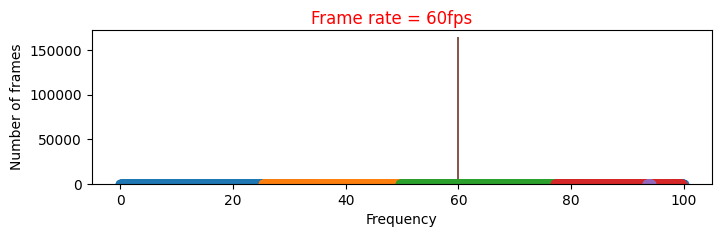

In [ ]:
dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
awake_ppseq_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
sleep_ppseq_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"

useable_mirs = ['EJT178_1_7','EJT149_1_1']

for mir in useable_mirs:
    # find organised path for each mir
    full_org_dat_path = find_organised_path(mir,dat_path)
    # load behavioural data
    behav_sync_df,transition_sync_df = load_behav_sync(full_org_dat_path)
    
    # load in awake ppseq data for the same mir and pull in linearised thingy
    awake_ppseq_base_path = find_awake_ppseq_base_path(mir,awake_ppseq_path)
    
    # load sequence order
    sequence_order = pd.read_csv(awake_ppseq_path + r'sequence_order.csv')
    # get continuous regions information
    continuous_regions_df = get_sequence_regions(mir,awake_ppseq_base_path,sequence_order)
    
    # tracking data 
    if 'EJT' in mir:
        back_head_centre_df,p1,p2,p3,p4,p5 = get_tracking_data_EJT_data(full_org_dat_path)
        
        #MAYBE I DONT NEED THIS - NOT REQUIRED THAT i ALIGN THE TRAKCING TO ANYTHING? THIS ANALYSIS IS SEPERATE? 
        # process/uncycle the raw timestamps
        camera_timestamps_df = process_raw_timestamps(full_org_dat_path)
    else:
        raise Exception("write this code Emmett!")
        
    ## extract simple metrics (number of trials, error rate, number of transitions,reward rate (vs time and vs transitions), number of each transition type)
    # number of trials
    num_trials = len(behav_sync_df.Trial_id.unique())
    # error rate
    correct_transit_rate, error_transit_rate, neutral_transit_rate = find_error_rates(transition_sync_df)
    # perfect sequence score (behavioural score)
    perf_score = get_perfect_sequence_score(transition_sync_df)
    # number of transitions
    total_transitions = len(transition_sync_df.Transition_type.values)
    # reward rate (vs time and vs transitions)
    transits_per_reward,seconds_per_reward = reward_rate(behav_sync_df)
    
    
    # movement variability for each motif region
    
    # time spend doing each motif?
    
    # motif specific errors? times the mouse diverged away from the optimal path. 
    
    break

['---',
 '#8FC681',
 '#ABB9B2',
 '#ED6F5D',
 '#64BFB5',
 '#36495E',
 '#FFD161',
 '#264999']

# tracking prep

overlap detected
overlap detected
overlap detected


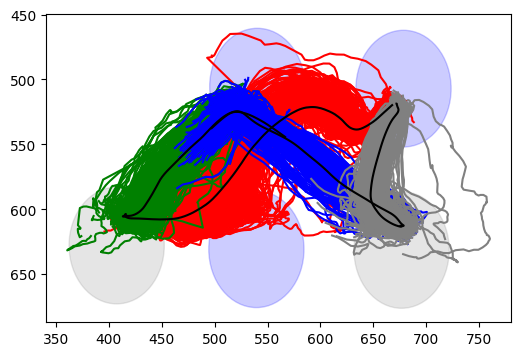

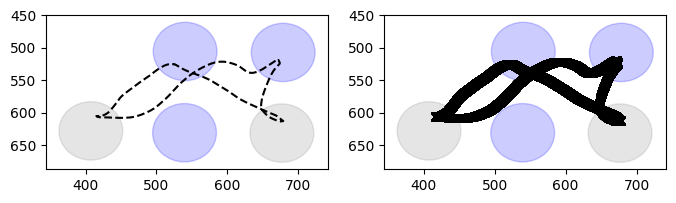

In [981]:
# find task relevant tracking periods, extract times mouse is close to each behavioural port
threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius = 45)

## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
fps = 1/np.mean(np.diff(camera_timestamps_df['Time Stamps'].values))
time_filter = 2 #in s
frame_filter = int(time_filter / (1/fps))

#we know when the mouse is close to each port, so find times when the mouse goes from port to port 
start_port,end_port = 5,2
T1_start_ind, T1_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,4,-1,-1)
start_port,end_port = 2,3
T2_start_ind, T2_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,4,5)
start_port,end_port = 3,4
T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,5)
start_port,end_port = 4,5
T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,3)

# find average curves by taking traject lines and make them roughly equivalent by interpolating so they have the same number of trakcing points, then for each point in each trajectory find the average xy position to create an average trajectory line 
a_curve1,a_curve2,a_curve3,a_curve4 = find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer = 10, radius = 45)

# join each curve, join them at the point that they touch, or if they dont touch just join the two ends to each other
new = join_curves(a_curve1, a_curve2,cut = True)
new = join_curves(new, a_curve3,cut = True)
new = join_curves(new, a_curve4,cut = True)
# join the two ends together to make a complete circle
complete_average = join_make_full_circle(new)

#interpolate to make standardspace:
standard_av_curve = resample_curve(complete_average, num_points = 10000)

# shift the start point of the curve so that is the first time the mous eleaves port 5 radius
standard_av_curve = shift_curve_start(standard_av_curve,port_centroids[-1])

# plot this stuff to check it looks okay
plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids)

# load in the seq colours 
seq_colours = np.load(awake_ppseq_base_path+ r'/analysis_output/reordered_recolored/colors',allow_pickle=True)

In [1045]:
def get_percentage_points(resampled_curve, percentages):
    """
    Get the points at specific percentage locations along the resampled curve.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param percentages: List of percentages (0-100) where points should be extracted
    :return: List of (x, y) points corresponding to the given percentages
    """
    num_points = len(resampled_curve)
    indices = [int(p / 100 * (num_points - 1)) for p in percentages]  # Convert percentage to index
    return resampled_curve[indices]

def plot_percentage_interval(resampled_curve, percentages,port_centroids,ax,sequence_name,colour_):
    """
    Plot the full resampled curve and highlight the region between two percentage points.
    
    :param resampled_curve: np.array of shape (N, 2), evenly spaced curve points
    :param percentages: List [start%, end%] defining the highlighted region
    """
    num_points = len(resampled_curve)
    start_idx = int(percentages[0] / 100 * (num_points - 1))
    end_idx = int(percentages[1] / 100 * (num_points - 1))

    # Handle case where interval wraps around (e.g., 97% to 14%)
    if start_idx <= end_idx:
        highlight_indices = range(start_idx, end_idx + 1)
    else:
        highlight_indices = list(range(start_idx, num_points)) + list(range(0, end_idx + 1))

    # Extract x, y coordinates
    x_vals, y_vals = resampled_curve[:, 0], resampled_curve[:, 1]


    # Plot full curve
    ax.plot(x_vals, y_vals, color='black', linewidth=1, label="Full Curve")

    # Highlight section
    highlighted_x = x_vals[list(highlight_indices)]
    highlighted_y = y_vals[list(highlight_indices)]
    ax.plot(highlighted_x, highlighted_y, color=colour_, linewidth=2, label="Highlighted Region")

    # Scatter start and end points
    ax.scatter([x_vals[start_idx], x_vals[end_idx]], 
                [y_vals[start_idx], y_vals[end_idx]], 
                color='blue', zorder=3, label="Start/End Points")

    for index,port_centroid in enumerate(port_centroids):
        circle1 = plt.Circle(port_centroid, radius_used, color='grey', alpha = 0.2)
        ax.add_patch(circle1)
        
    ax.set_title(f"sequence {int(sequence_name)+1}")
        
    ax.invert_yaxis()
    
def find_motif_start_end_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours):
    start_ends= []
    fig, axs = plt.subplots(1,len(continuous_regions_df),figsize=(4*len(continuous_regions_df), 2))
    for i,row in continuous_regions_df.iterrows():
        ## add a small 2% buffer to each side. % of total standard curve that is - so added amount is same for each motif
        buffer_ = 2
        start = row.start-buffer_
        if start < 0:
            start = 100 + start 
        end = row.end+buffer_
        if end > 100:
            end = 0 + (100-end)
        s_,e_ = get_percentage_points(standard_av_curve,[start,end])
        plot_percentage_interval(standard_av_curve,[start,end],port_centroids,axs[i],row.sequence,seq_colours[int(row.sequence)+1])
        start_ends +=[[s_,e_]]
    return pd.DataFrame(start_ends, columns=["start_xy", "end_xy"])

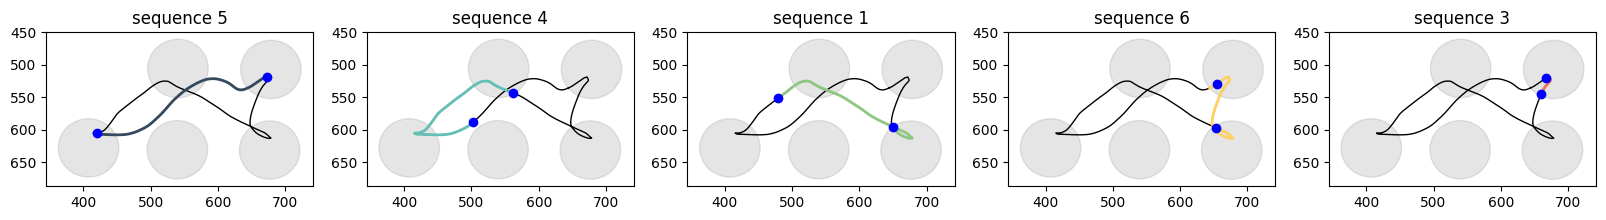

In [1096]:

# next define the regions of each motif 
motif_start_ends_df = find_motif_start_end_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours)

# now take these start and end points of each motif to find all motif examples (use a radius and maybe time filter) 
# this should give me all motif executions
# then find the variability..deviation from trajectory, speed, time spent doing motif etc.  

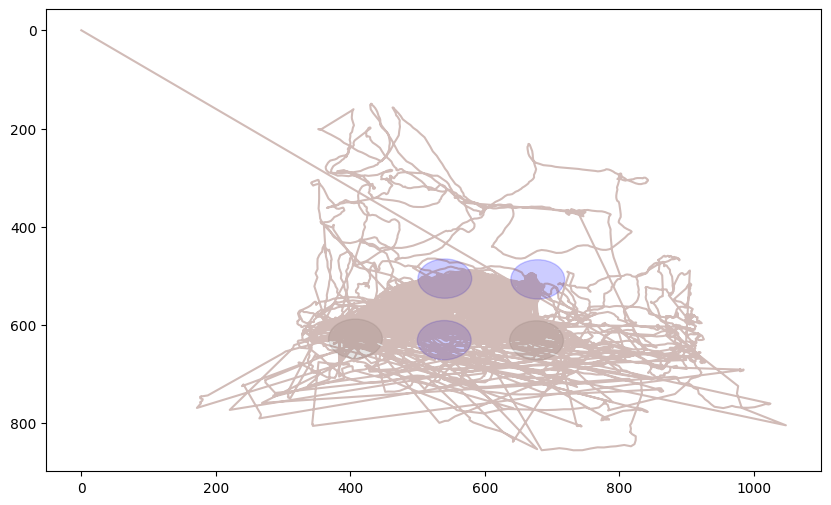

In [592]:
port_centroids = [(np.median(p1.interped_x),np.median(p1.interped_y)),(np.median(p2.interped_x),np.median(p2.interped_y)),(np.median(p3.interped_x),np.median(p3.interped_y)),(np.median(p4.interped_x),np.median(p4.interped_y)),(np.median(p5.interped_x),np.median(p5.interped_y))]

fig, ax = plt.subplots(1, 1,figsize=(10, 6))
for index,port_centroid in enumerate(port_centroids):
    ## define rings around important ports: port 5, port2, port 3, port4
    radius = 40
    ax.plot(port_centroid[0],port_centroid[1],'o',alpha = 0)
    c = ['blue','grey','blue','grey','blue']
    circle = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
    ax.add_patch(circle)
ax.invert_yaxis()

ax.plot(back_head_centre_df.interped_x,back_head_centre_df.interped_y,'-',alpha = 0.4)

88218.16799999999

In [652]:
behav_sync_df

,Unnamed: 0,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
0,0,1,33.5779,7,39.1177,39.3896,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,347.811700,20520.0,342.000000,347.539800,347.811700,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
1,1,1,33.5779,7,39.5222,39.7818,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,348.203900,20520.0,342.000000,347.944300,348.203900,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2,2,1,33.5779,7,45.3722,45.9151,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,354.337200,20520.0,342.000000,353.794300,354.337200,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3,3,1,33.5779,1,46.7517,47.4965,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,355.918600,20520.0,342.000000,355.173800,355.918600,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
4,4,1,33.5779,3,49.2089,49.3717,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,357.793800,20520.0,342.000000,357.631000,357.793800,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,2177,277,2411.2686,6,2414.8285,2415.0117,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2724.709767,163258.0,2720.966667,2724.526567,2724.709767,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2178,2178,277,2411.2686,3,2415.3505,2415.7008,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2725.398867,163258.0,2720.966667,2725.048567,2725.398867,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2179,2179,277,2411.2686,2,2415.3840,2415.5804,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2725.278467,163258.0,2720.966667,2725.082067,2725.278467,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2180,2180,277,2411.2686,2,2415.5868,2415.6890,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2725.387067,163258.0,2720.966667,2725.284867,2725.387067,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [649]:
np.argmin(np.abs(camera_timestamps_df['Time Stamps'].values - current_poke_in_time))

88257

In [651]:
camera_timestamps_df[88257::]

,Time Stamps,Trigger State
88257,1470.304875,0.0
88258,1470.321500,0.0
88259,1470.338125,0.0
88260,1470.354750,0.0
88261,1470.371500,0.0
...,...,...
164721,2744.169375,0.0
164722,2744.186000,0.0
164723,2744.202625,0.0
164724,2744.219375,0.0


In [648]:
camera_timestamps_df['Time Stamps'].values

array([0.00000000e+00, 1.66250000e-02, 3.32500000e-02, ...,
       2.74420262e+03, 2.74421937e+03, 2.74423600e+03])

In [647]:
np.abs(camera_timestamps_df['Time Stamps'].values - current_poke_in_time)

array([1470.3028  , 1470.286175, 1470.26955 , ..., 1273.899825,
       1273.916575, 1273.9332  ])

In [644]:
camera_timestamps_df

,Time Stamps,Trigger State
0,0.000000,0.0
1,0.016625,0.0
2,0.033250,0.0
3,0.049875,0.0
4,0.066625,0.0
...,...,...
164721,2744.169375,0.0
164722,2744.186000,0.0
164723,2744.202625,0.0
164724,2744.219375,0.0


In [641]:
chosen_indices

array([1240, 1612,  198, 1245,  563,  495, 1832,  570, 1535,  775,   63,
       1970,  313,  414,  814,  240, 1591, 2055, 1355, 2101,  447,   98,
       2118, 1547,    3, 2155,  698, 1328, 1514,  624, 2148, 1164, 1507,
        320, 1362,  712,  676, 1888,  972,  866], dtype=int64)

In [634]:
len(behav_sync_df)

2182

In [633]:
behav_sync_df

,Unnamed: 0,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
0,0,1,33.5779,7,39.1177,39.3896,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,347.811700,20520.0,342.000000,347.539800,347.811700,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
1,1,1,33.5779,7,39.5222,39.7818,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,348.203900,20520.0,342.000000,347.944300,348.203900,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2,2,1,33.5779,7,45.3722,45.9151,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,354.337200,20520.0,342.000000,353.794300,354.337200,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3,3,1,33.5779,1,46.7517,47.4965,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,355.918600,20520.0,342.000000,355.173800,355.918600,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
4,4,1,33.5779,3,49.2089,49.3717,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,357.793800,20520.0,342.000000,357.631000,357.793800,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,2177,277,2411.2686,6,2414.8285,2415.0117,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2724.709767,163258.0,2720.966667,2724.526567,2724.709767,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2178,2178,277,2411.2686,3,2415.3505,2415.7008,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2725.398867,163258.0,2720.966667,2725.048567,2725.398867,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2179,2179,277,2411.2686,2,2415.3840,2415.5804,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2725.278467,163258.0,2720.966667,2725.082067,2725.278467,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2180,2180,277,2411.2686,2,2415.5868,2415.6890,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",...,2725.387067,163258.0,2720.966667,2725.284867,2725.387067,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [600]:
back_head_centre_df

coords,x,y,likelihood,interped_x,interped_y
0,366.061066,584.250671,0.999597,366.061066,584.250671
1,365.491608,585.148315,0.999591,365.491608,585.148315
2,364.315460,585.561768,0.999709,364.315460,585.561768
3,363.241913,585.304504,0.999731,363.241913,585.304504
4,362.535126,584.520691,0.999748,362.535126,584.520691
...,...,...,...,...,...
164722,0.000000,0.000000,0.000177,0.000000,0.000000
164723,0.000000,0.000000,0.000294,0.000000,0.000000
164724,0.000000,0.000000,0.000203,0.000000,0.000000
164725,0.000000,0.000000,0.000064,0.000000,0.000000


In [ ]:
## take code which finds full sequences from tracking data 
# find average line
# split the data into the different motif areas 
# find the mean variability of each motif area

# number of motifs performed/ time spent doing each motif  



In [2]:
### is there a link between behaviour and the replay we see? 

## load all the replay sessions that i have...
## look for a correlation:
# number of trials
# amount of each motif
# how variable each motif is
# number of errors
# reward rate
# others?

# so i need to load the behavioural data to take standard measures
# then take the tracking data to extract variability
# most complicated will be working out how to map the motifs to the task.. 
# # should be okay because I know where on the linearised task thye sit so i just take these positions. 


# do these correlate with replay rate, a characteristic of replay? motif specific replay? 

In [ ]:
## is there a link between replay and behaviour?

# need session before and after - take basic meausures as before 
# I think take same meausures as before 
# does replay predict a change? 
